# Load DataSet

In [8]:
import numpy as np

!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
data = np.load('Data.npz')
print(data.files)

--2021-08-16 17:04:54--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  8.44MB/s    in 2.2s    

2021-08-16 17:04:57 (8.44 MB/s) - ‘Data.npz’ saved [19725078/19725078]

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


# Visualize Dataset

dataset is unballance, need some help to improve it.

In [9]:
import numpy as np

x_train = data['train_images']
y_train = data['train_labels']

x_val = data['val_images']
y_val = data['val_labels']

x_test = data['test_images']
y_test = data['test_labels']

print('Labels: ', np.unique(y_train))
labels_number = len(np.unique(y_train))

print('train_images shape: ', data['train_images'].shape)
print('train_labels shape: ', data['train_labels'].shape)

print('val_images shape: ', data['val_images'].shape)
print('val_labels shape: ', data['val_labels'].shape)

print('test_images shape: ', data['test_images'].shape)
print('test_labels shape: ', data['test_labels'].shape)

Labels:  [0 1 2 3 4 5 6]
train_images shape:  (7007, 28, 28, 3)
train_labels shape:  (7007, 1)
val_images shape:  (1003, 28, 28, 3)
val_labels shape:  (1003, 1)
test_images shape:  (2005, 28, 28, 3)
test_labels shape:  (2005, 1)


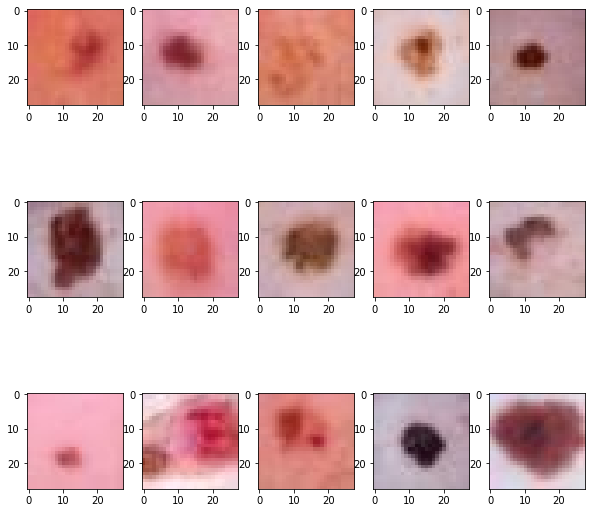

In [10]:
def plot_img(x_train, y_train):
    from matplotlib import pyplot as plt
    fig=plt.figure(figsize=(10, 10))
    columns = 5
    rows = 3
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        img = x_train[i]
        plt.imshow(img)
        # plt.title(y_train[i][0])
    plt.show()
plot_img(x_train, y_train)

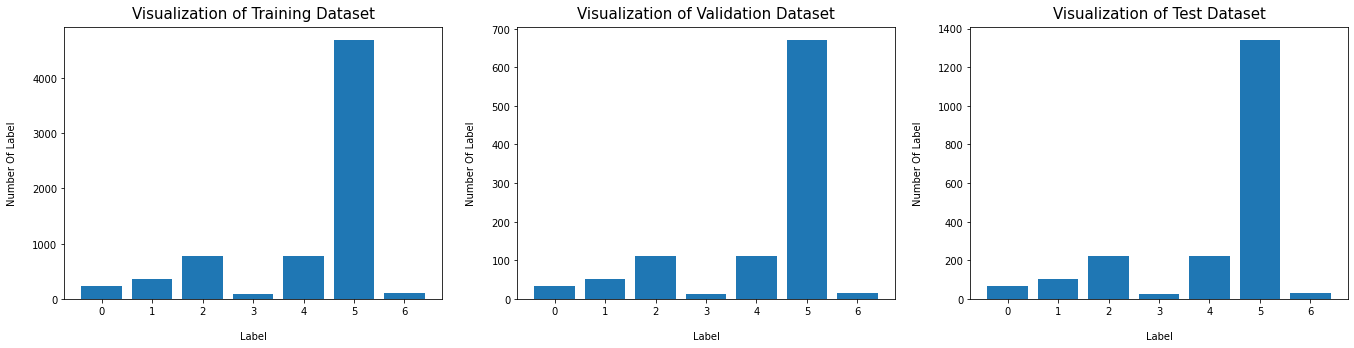

In [11]:
from matplotlib import pyplot as plt

def data_summary(y):
    data = dict()
    for i in range(labels_number):
        data[str(i)] = (int)(np.sum(y==i))
    group_data = list(data.values())
    group_names = list(data.keys())
    return group_data, group_names

def draw_ax(i, group_data, group_names, title):
    ax[i].bar(group_names, group_data)
    ax[i].set_title("Visualization of "+ title , y=1.01, fontsize=15)
    ax[i].set_ylabel("Number Of Label", labelpad=15)
    ax[i].set_xlabel("Label", labelpad=15)

fig, ax = plt.subplots(1, 3, figsize=(23, 5))

group_data, group_names = data_summary(y_train)
draw_ax(0, group_data, group_names, "Training Dataset")

group_data, group_names = data_summary(y_val)
draw_ax(1, group_data, group_names, "Validation Dataset")

group_data, group_names = data_summary(y_test)
draw_ax(2, group_data, group_names, "Test Dataset")


# Preprocess on dataset

normalize the images to range (0 , 1)

In [12]:
import tensorflow

x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

y_train = tensorflow.keras.utils.to_categorical(y_train, labels_number)
y_val = tensorflow.keras.utils.to_categorical(y_val, labels_number)
y_test = tensorflow.keras.utils.to_categorical(y_test, labels_number)


In [13]:
print(y_train.shape)
print(x_train.shape)

(7007, 7)
(7007, 28, 28, 3)


# General Function

In [14]:
def unison_shuffle(a, b):
    idx = np.random.permutation(a.shape[0])
    return a[idx], b[idx]

def classification_report(model, x_test, y_test):
    from sklearn.metrics import classification_report
    y_pred = model.predict(x_test)
    y_pred_classes = [np.argmax(element) for element in y_pred]
    y_test_classes = [np.argmax(element) for element in y_test]
    print("Classification Report: \n", classification_report(y_test_classes, y_pred_classes))

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > threshold else "black")
            texts.append(text)

    return texts
def confusion_matrix(model, x_test, y_test):
    labels = ['0', '1', '2', '3', '4', '5', '6']
    from sklearn.metrics import confusion_matrix
    pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(pred, axis=1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(Y_true, Y_pred_classes) 
    thresh = cm.max() / 2.

    fig, ax = plt.subplots(figsize=(6,6))
    im, cbar = heatmap(cm, labels, labels, ax=ax,
                      cmap=plt.cm.Blues, cbarlabel="count of predictions")
    texts = annotate_heatmap(im, data=cm, threshold=thresh)

    fig.tight_layout()
    plt.show()

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()


# Simple Model (No preprocess dataset)
here without normalization we get good performance

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 256)       

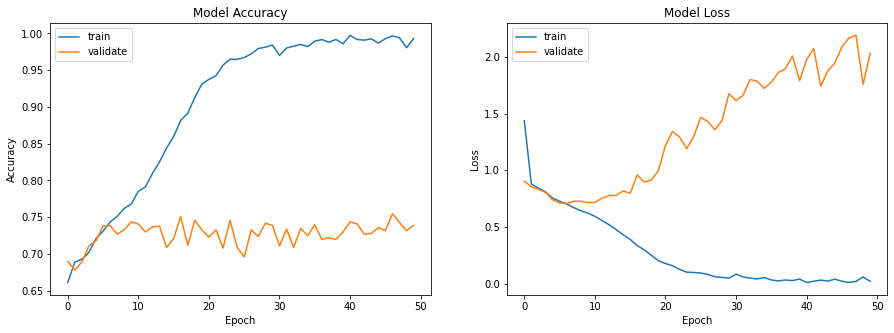

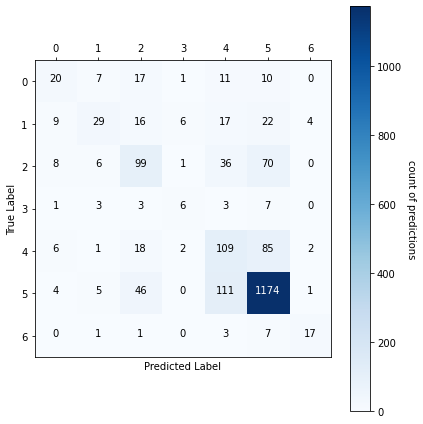

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

x_train = data['train_images']
y_train = data['train_labels']

x_val = data['val_images']
y_val = data['val_labels']

x_test = data['test_images']
y_test = data['test_labels']

y_train = tensorflow.keras.utils.to_categorical(y_train, labels_number)
y_val = tensorflow.keras.utils.to_categorical(y_val, labels_number)
y_test = tensorflow.keras.utils.to_categorical(y_test, labels_number)

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                                   # recpective field: 36*36

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')) # recpective field: 34*34
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')) # recpective field: 32*32
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                   # recpective field: 16*16

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')) # recpective field: 12*12
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                    # recpective field: 6*6


model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')) # recpective field: 4*4
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')) # recpective field: 2*2
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(512, activation='relu', name='fc1'))
model.add(Dense(512, activation='relu', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    metrics=["accuracy"],
)
x_train, y_train = unison_shuffle(x_train, y_train)

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


# Simple Model
* dataset is unbalanced!
* correct evaluation metric shows all input predicted to be align in class 5. 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 256)        

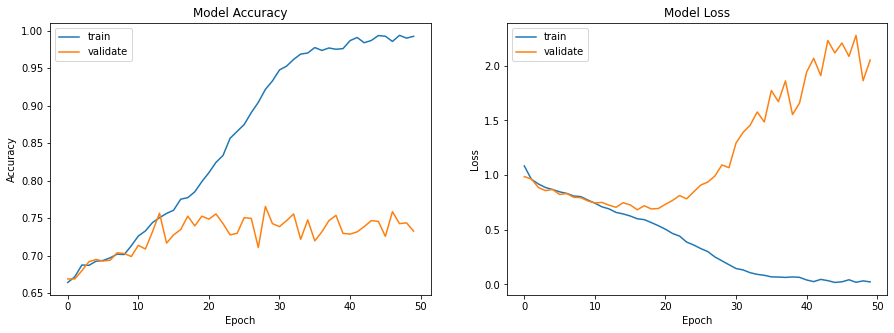

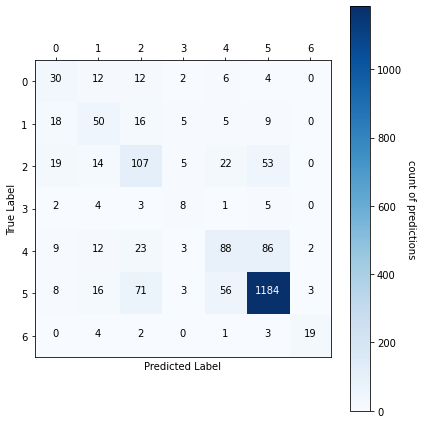

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

x_train = data['train_images']
y_train = data['train_labels']

x_val = data['val_images']
y_val = data['val_labels']

x_test = data['test_images']
y_test = data['test_labels']


x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

y_train = tensorflow.keras.utils.to_categorical(y_train, labels_number)
y_val = tensorflow.keras.utils.to_categorical(y_val, labels_number)
y_test = tensorflow.keras.utils.to_categorical(y_test, labels_number)

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                                   # recpective field: 36*36

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')) # recpective field: 34*34
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')) # recpective field: 32*32
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                   # recpective field: 16*16

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')) # recpective field: 12*12
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                    # recpective field: 6*6


model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')) # recpective field: 4*4
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')) # recpective field: 2*2
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(512, activation='relu', name='fc1'))
model.add(Dense(512, activation='relu', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    metrics=["accuracy"],
)
x_train, y_train = unison_shuffle(x_train, y_train)

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 128)         7

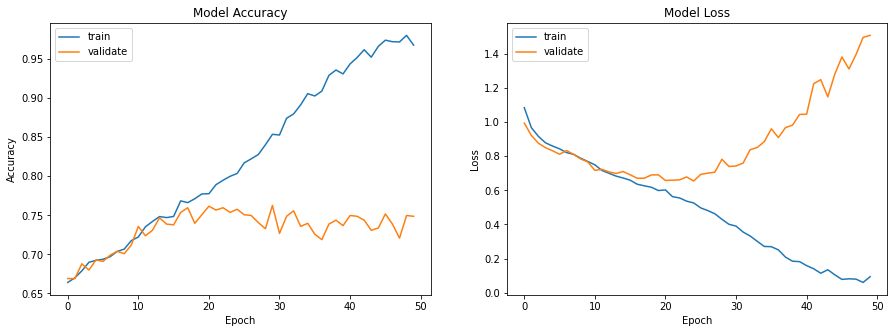

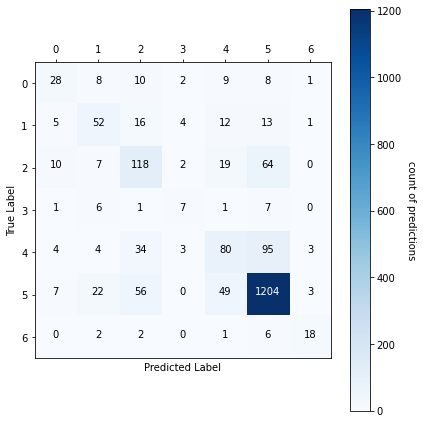

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2')) 
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                   


model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dense(256, activation='relu', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    metrics=["accuracy"],
)
x_train, y_train = unison_shuffle(x_train, y_train)

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 128)       

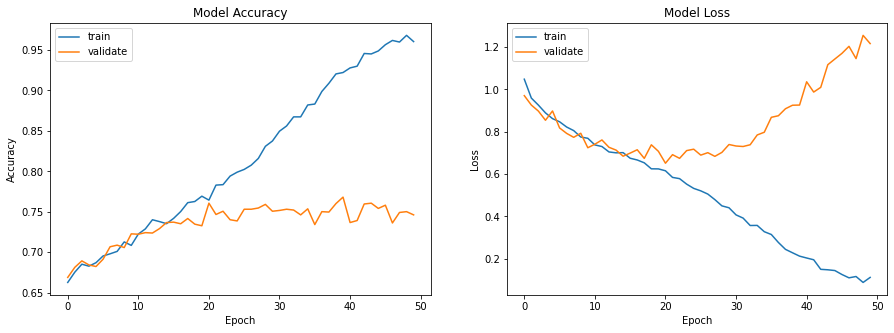

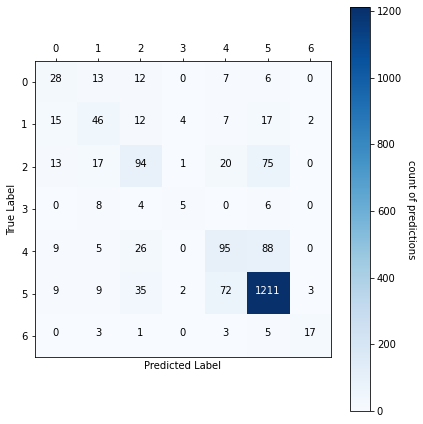

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, Dropout
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

def create_model():
        
    model = Sequential()
    model.add( InputLayer((28, 28, 3)))                                                   # recpective field: 36*36

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')) # recpective field: 34*34
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')) # recpective field: 32*32
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                   # recpective field: 16*16
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')) # recpective field: 12*12
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                    # recpective field: 6*6
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')) # recpective field: 4*4
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')) # recpective field: 2*2
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    model.add(Dropout(0.2))

    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu', name='fc1'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='softmax', name='predictions'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model
model = create_model()

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), verbose=1)


classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)



Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 128)       

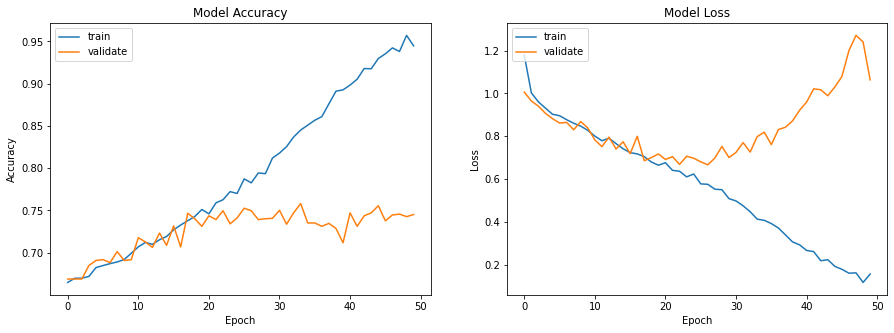

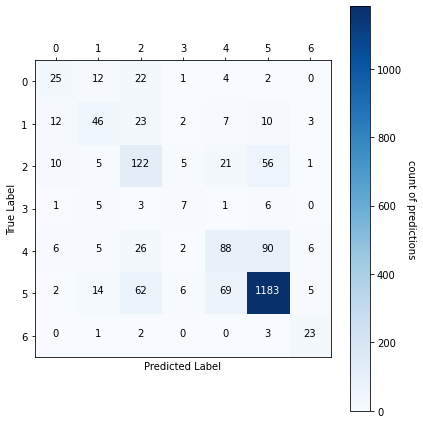

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, Dropout
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

def create_model():
        
    model = Sequential()
    model.add( InputLayer((28, 28, 3)))                                                   # recpective field: 36*36

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')) # recpective field: 34*34
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')) # recpective field: 32*32
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                   # recpective field: 16*16
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')) # recpective field: 12*12
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                    # recpective field: 6*6
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')) # recpective field: 4*4
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')) # recpective field: 2*2
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_conv1')) # recpective field: 4*4
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_conv2')) # recpective field: 2*2
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    model.add(Dropout(0.2))

    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu', name='fc1'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='softmax', name='predictions'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model
model = create_model()

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), verbose=1)


classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)



# Resolve Unbalancement by augmentaion and up and down sampling

even after remove unbalancement --> not good effect on performance(you can check evaluation metrics)

* I resample and use 90, 180, 270 degree rotated images. 
* I concat train and validation data to increase data and just use test data to evaluation.

In [ ]:
import numpy as np

data = np.load('Data.npz')
print(data.files)

x_train = data['train_images']
y_train = data['train_labels']

x_val = data['val_images']
y_val = data['val_labels']

x_test = data['test_images']
y_test = data['test_labels']


print(x_train.shape)
print(y_train.shape)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']
(7007, 28, 28, 3)
(7007, 1)


In [ ]:
import tensorflow

labels_number = 7
data = np.array(7*[None])
x_train=np.concatenate((x_train,x_val), axis=0)
y_train=np.concatenate((y_train,y_val), axis=0)

for i in range(7):
    data[i] = x_train[np.where(y_train==i)[0]]

sample_num=4000
for i in range(7):
    data_size = data[i].shape[0]
    if data_size > sample_num:
        data[i] = data[i][:sample_num]
    else:
        r = (int)(sample_num / data_size)
        g = (int)(sample_num % data_size)
        x_augmentation = np.copy(data[i])
        for k in range(r-1):
            for j in range(data_size):
                x_augmentation[j] = np.rot90(x_augmentation[j])
            data[i] = np.concatenate((data[i], x_augmentation), axis=0)
        data[i] = np.concatenate((data[i], data[i][:g]), axis=0)

x_tra = data[0]
y_tra = np.zeros(sample_num)
for i in range(6):
    x_tra = np.concatenate((x_tra, data[i+1]), axis=0) 
    y_tra = np.concatenate((y_tra, np.ones(data[i+1].shape[0])*(i+1)), axis=0)
 
x_tra, y_tra = unison_shuffle(x_tra, y_tra)

x_tra = x_tra / 255.0
x_test = x_test / 255.0
y_tra = tensorflow.keras.utils.to_categorical(y_tra, labels_number)
y_test = tensorflow.keras.utils.to_categorical(y_test, labels_number)

print(x_tra.shape)
print(y_tra.shape)

(28000, 28, 28, 3)
(28000, 7)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


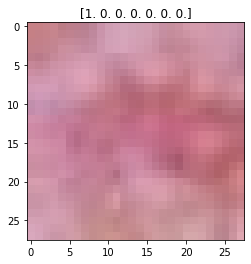

In [ ]:
from matplotlib import pyplot as plt

j=100
plt.imshow(x_tra[j])
plt.title(y_tra[j])
plt.show()

# Simple Model on balance data

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0   

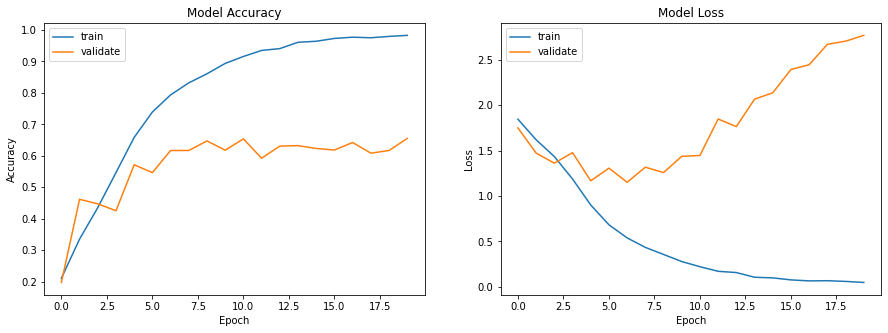

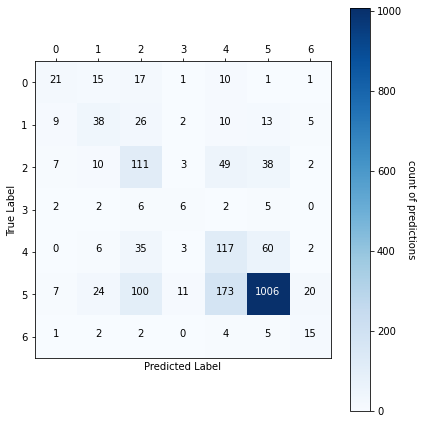

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, Dropout
from tensorflow import keras
from tensorflow.keras.models import Model

def create_model():
    input_lay = keras.Input(shape=(28, 28, 3))

    x = Conv2D(64, (3, 3), padding='same', activation='softplus', name='block1_conv1')(input_lay)
    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    outputs = Dense(7, activation='softmax', name='predictions')(x)

    model = Model(inputs=input_lay, outputs=outputs)
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model

model = create_model()

history = model.fit(x_tra, y_tra, batch_size=64, epochs=20, validation_data=(x_test, y_test), verbose=1)


classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)



* ***copy of previous model( Use Sequentionl model)***

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 256)         2

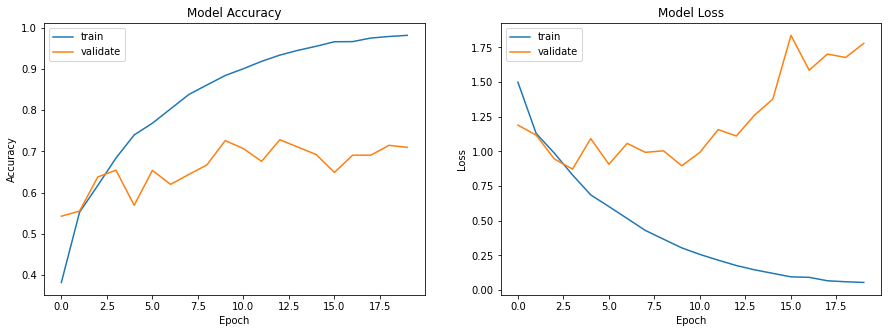

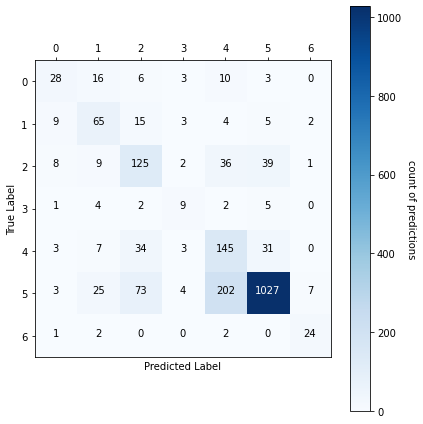

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, Dropout
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

def create_model():
        
    model = Sequential()
    model.add( InputLayer((28, 28, 3)))                                                   # recpective field: 36*36

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')) # recpective field: 34*34
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')) # recpective field: 32*32
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                   # recpective field: 16*16

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')) # recpective field: 12*12
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                    # recpective field: 6*6


    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')) # recpective field: 4*4
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')) # recpective field: 2*2
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu', name='fc1'))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(Dense(7, activation='softmax', name='predictions'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model
model = create_model()

history = model.fit(x_tra, y_tra, batch_size=64, epochs=20, validation_data=(x_test, y_test), verbose=1)


classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)



# Use Dropout to avoid overfitting

* Dropout avoid overfitting
* i used a light weight Dropout --> not removed overfitting completely but reduced it.
* heavy dropout result is poor performance
* in my practice dropout has better performance than regularization i

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0   

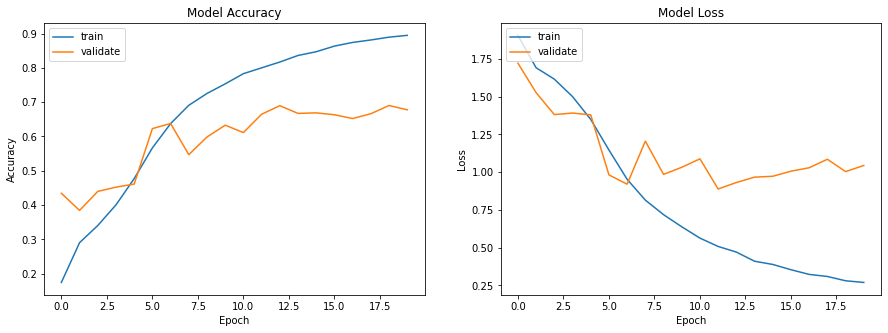

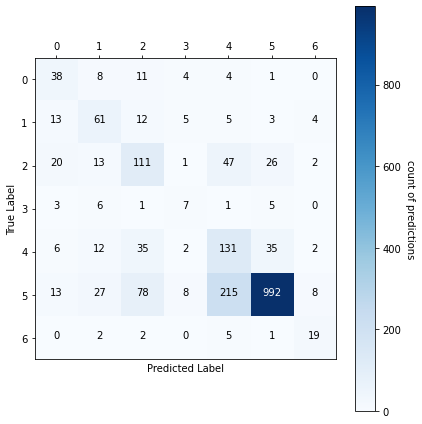

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, Dropout
from tensorflow import keras
from tensorflow.keras.models import Model

def create_model():
    input_lay = keras.Input(shape=(28, 28, 3))

    x = Conv2D(64, (3, 3), padding='same', activation='softplus', name='block1_conv1')(input_lay)
    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    x = Dropout(0.2)(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(7, activation='softmax', name='predictions')(x)

    model = Model(inputs=input_lay, outputs=outputs)
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model

model = create_model()
print(x_tra.shape, y_tra.shape)
history = model.fit(x_tra, y_tra, batch_size=64, epochs=20, validation_data=(x_test, y_test), verbose=1)


classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7, 128)        

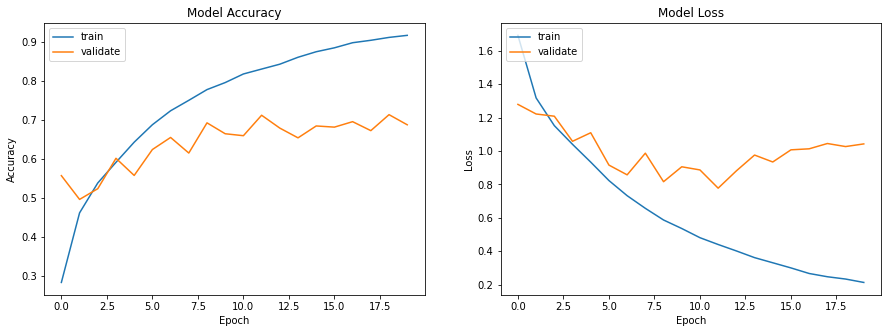

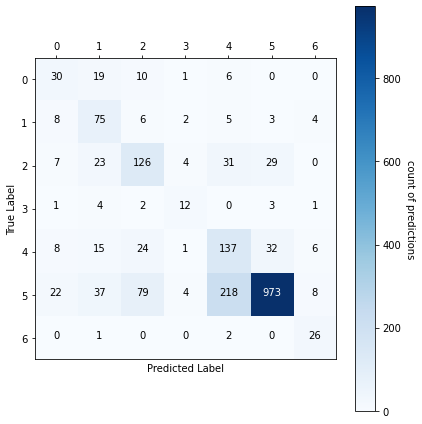

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, Dropout
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

def create_model():
        
    model = Sequential()
    model.add( InputLayer((28, 28, 3)))                                                   # recpective field: 36*36

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')) # recpective field: 34*34
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')) # recpective field: 32*32
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                   # recpective field: 16*16
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')) # recpective field: 12*12
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                    # recpective field: 6*6
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')) # recpective field: 4*4
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')) # recpective field: 2*2
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    model.add(Dropout(0.2))

    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu', name='fc1'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='softmax', name='predictions'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model
model = create_model()

history = model.fit(x_tra, y_tra, batch_size=64, epochs=20, validation_data=(x_test, y_test), verbose=1)


classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)



#Use Regularization
* L1 Regularization:

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 256)        

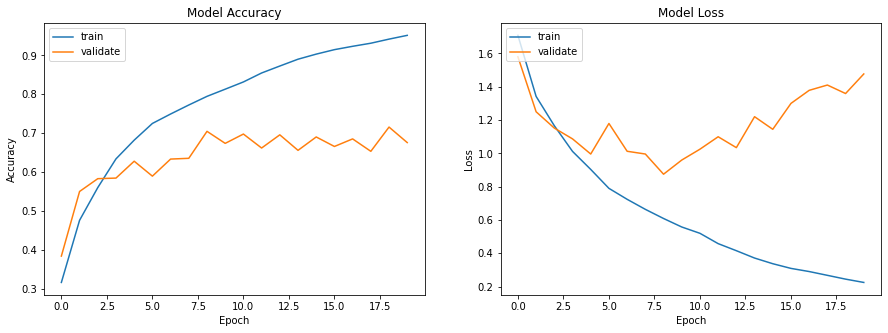

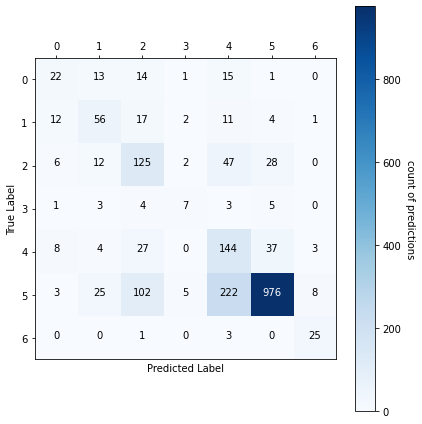

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, Dropout
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model


def create_model():
    regularizer = keras.regularizers.l2(1e-4)        
    model = Sequential()
    model.add( InputLayer((28, 28, 3)))                                                   # recpective field: 36*36

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1', kernel_regularizer=regularizer)) # recpective field: 34*34
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2', kernel_regularizer=regularizer)) # recpective field: 32*32
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                   # recpective field: 16*16

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1', kernel_regularizer=regularizer)) 
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2', kernel_regularizer=regularizer)) # recpective field: 12*12
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                    # recpective field: 6*6


    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1', kernel_regularizer=regularizer)) # recpective field: 4*4
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2', kernel_regularizer=regularizer)) # recpective field: 2*2
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu', name='fc1', kernel_regularizer=regularizer))
    model.add(Dense(512, activation='relu', name='fc2', kernel_regularizer=regularizer))
    model.add(Dense(7, activation='softmax', name='predictions'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model
model = create_model()

history = model.fit(x_tra, y_tra, batch_size=64, epochs=20, validation_data=(x_test, y_test), verbose=1)


classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)



* L1 Regularizer

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 256)       

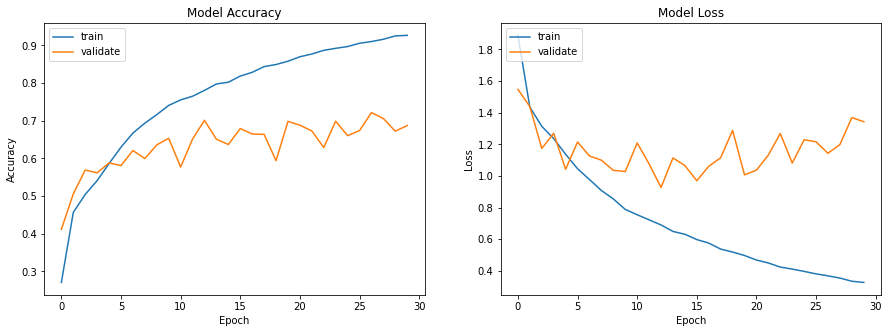

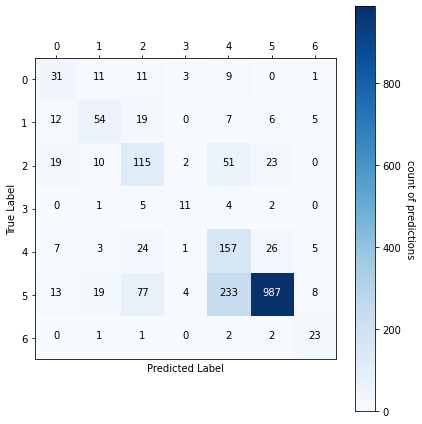

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, Dropout
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model


def create_model():
    regularizer = keras.regularizers.l1(1e-5)
    model = Sequential()
    model.add( InputLayer((28, 28, 3)))                                                   # recpective field: 36*36

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')) # recpective field: 34*34
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')) # recpective field: 32*32
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                   # recpective field: 16*16

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1', kernel_regularizer=regularizer)) 
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2', kernel_regularizer=regularizer)) # recpective field: 12*12
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                    # recpective field: 6*6


    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1', kernel_regularizer=regularizer)) # recpective field: 4*4
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2', kernel_regularizer=regularizer)) # recpective field: 2*2
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu', name='fc1', kernel_regularizer=regularizer))
    model.add(Dense(512, activation='relu', name='fc2', kernel_regularizer=regularizer))
    model.add(Dense(7, activation='softmax', name='predictions'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model
model = create_model()

history = model.fit(x_tra, y_tra, batch_size=64, epochs=30, validation_data=(x_test, y_test), verbose=1)


classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)



# Regularizer + Dropout

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)       

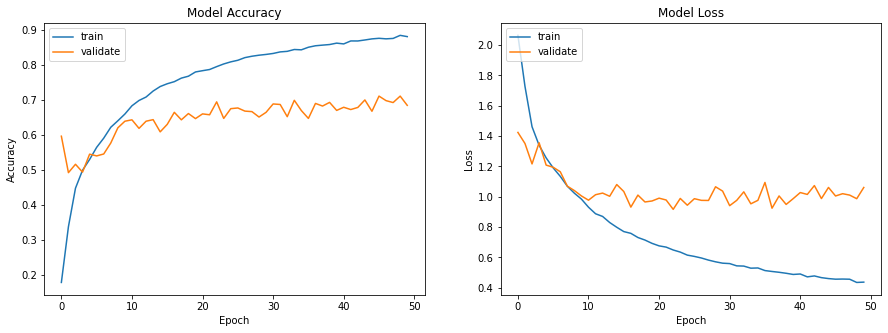

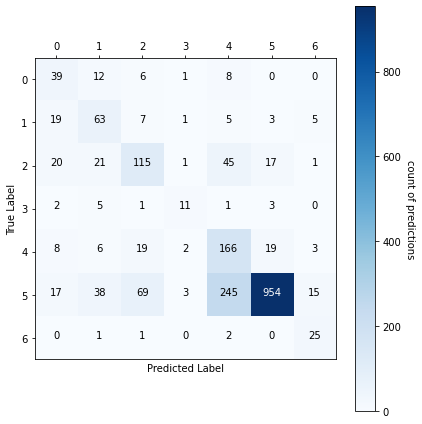

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, Dropout
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model


def create_model():
    regularizer = keras.regularizers.l2(1e-4)        
    model = Sequential()
    model.add( InputLayer((28, 28, 3)))                                                   # recpective field: 36*36

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1', kernel_regularizer=regularizer)) # recpective field: 34*34
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2', kernel_regularizer=regularizer)) # recpective field: 32*32
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                   # recpective field: 16*16
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1', kernel_regularizer=regularizer)) 
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2', kernel_regularizer=regularizer)) # recpective field: 12*12
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                    # recpective field: 6*6
    model.add(Dropout(0.5))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1', kernel_regularizer=regularizer)) # recpective field: 4*4
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2', kernel_regularizer=regularizer)) # recpective field: 2*2
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    model.add(Dropout(0.5))

    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu', name='fc1', kernel_regularizer=regularizer))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', name='fc2', kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='softmax', name='predictions'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model
model = create_model()

history = model.fit(x_tra, y_tra, batch_size=64, epochs=50, validation_data=(x_test, y_test), verbose=1)


classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)



# Non-linear model uning keras functional api
we can use non-functional keras api to avoid gradient vanishing(ResNet idea) && even in unbalnce dataset we can create an specific model to adjust a weight for each output class.  

here i just use for gradient vanishing.
result: i'm not satisfy with the model -->  it has poor performance.

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 28, 28, 64)   1792        input_32[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 28, 28, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 14, 14, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

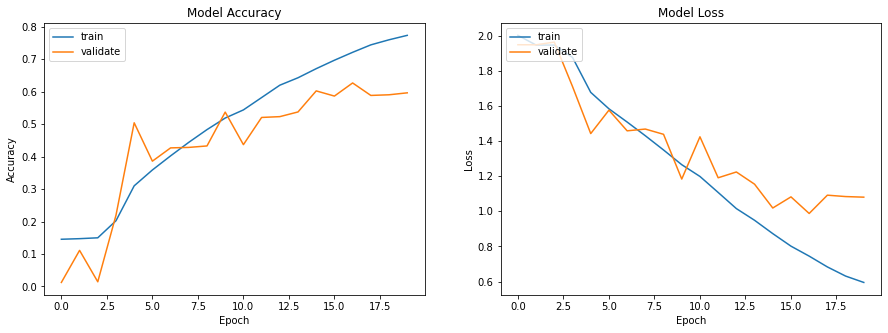

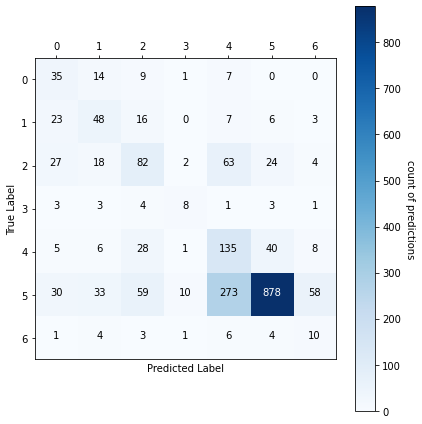

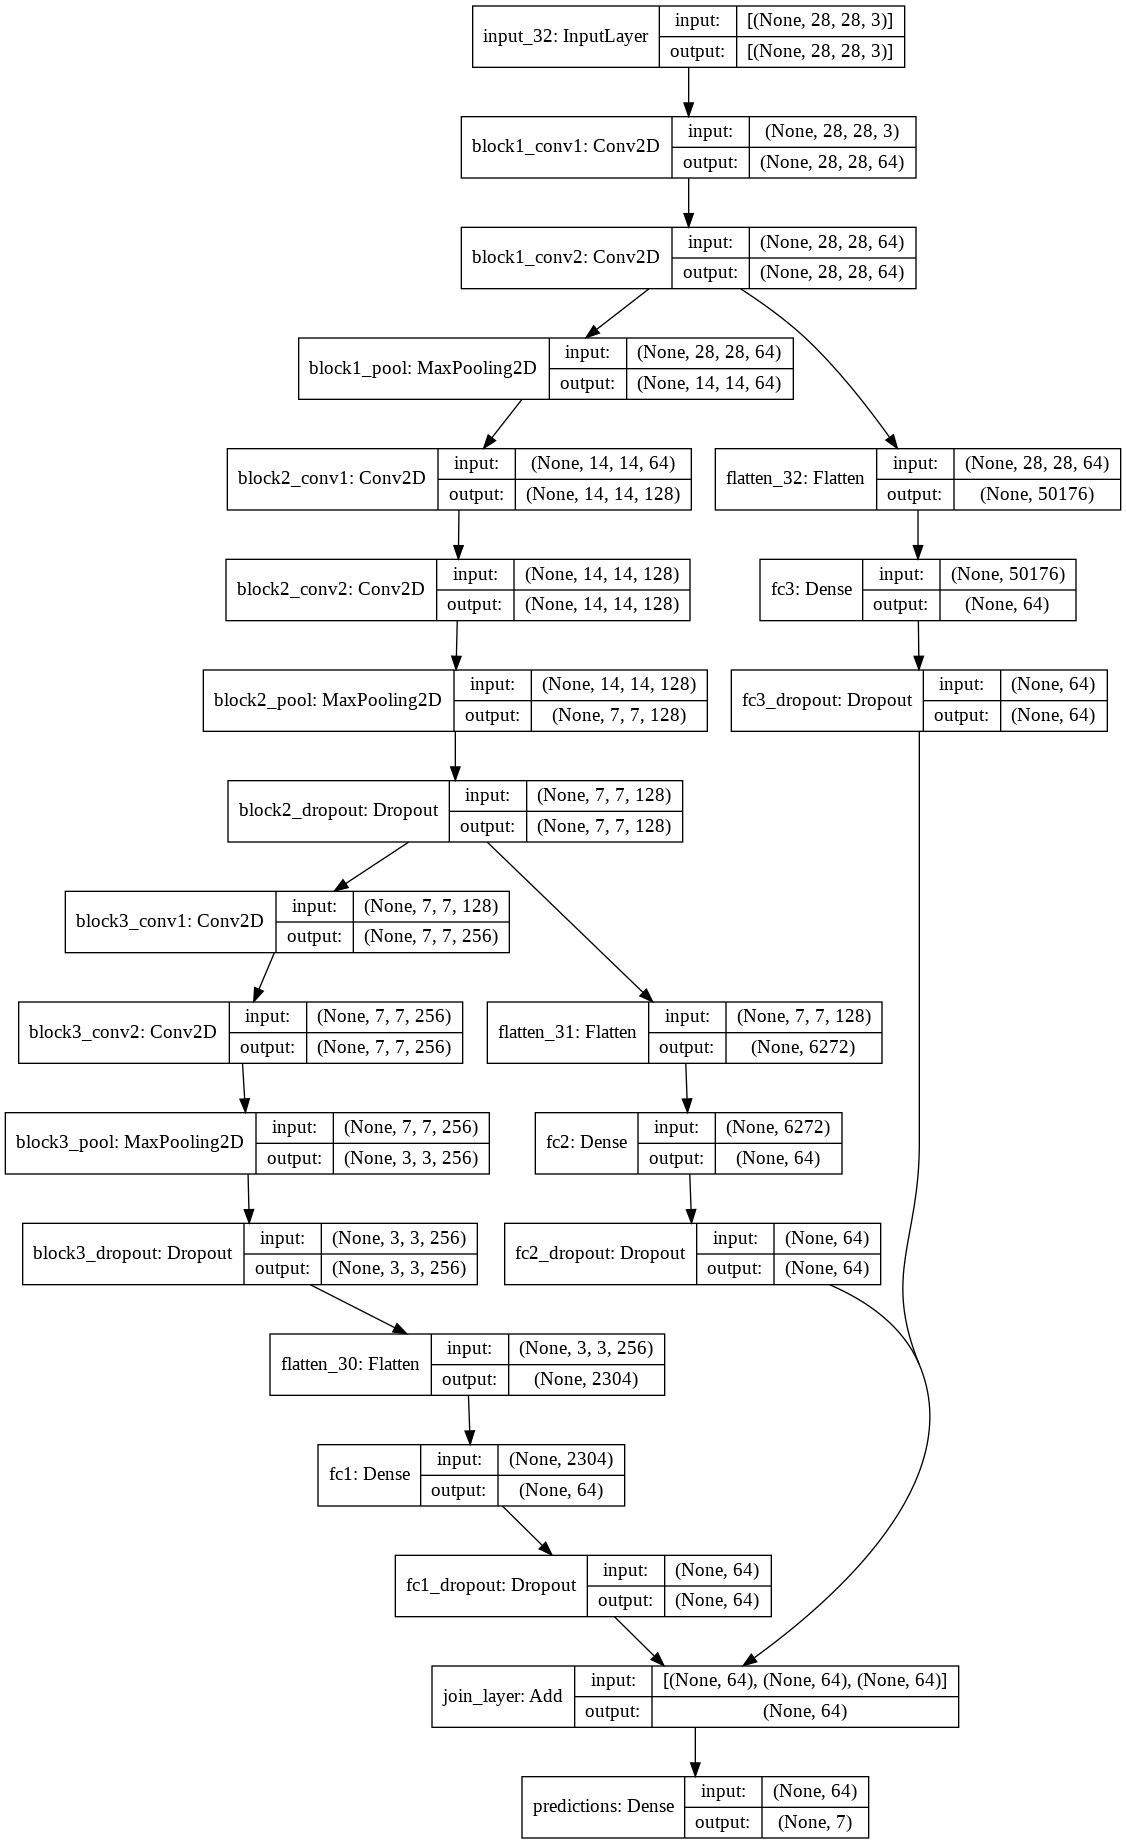

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, Dropout, add
from tensorflow import keras
from tensorflow.keras.models import Model

def create_model():
    input_lay = keras.Input(shape=(28, 28, 3))

    x1 = Conv2D(64, (3, 3), padding='same', activation='softplus', name='block1_conv1')(input_lay)
    x2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')(x1)
    x3 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x2)

    x4 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')(x3)
    x5 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')(x4)
    x6 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x5)
    x7 = Dropout(0.2, name='block2_dropout')(x6)

    x8 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')(x7)
    x9 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')(x8)
    x10 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x9)
    x11 = Dropout(0.2, name='block3_dropout')(x10)
    

    x12 = Flatten()(x11)
    x13 = Dense(64, activation='relu', name='fc1')(x12)
    x14 = Dropout(0.2, name='fc1_dropout')(x13)

    x15 = Flatten()(x7)
    x16 = Dense(64, activation='relu', name='fc2')(x15)
    x17 = Dropout(0.2, name='fc2_dropout')(x16)

    x18 = Flatten()(x2)
    x19 = Dense(64, activation='relu', name='fc3')(x18)
    x20 = Dropout(0.3, name='fc3_dropout')(x19)

    x21 = add([x14, x17, x20], name='join_layer')
    outputs = Dense(7, activation='softmax', name='predictions')(x21)
    model = Model(inputs=input_lay, outputs=outputs)
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model

model = create_model()
print(x_tra.shape, y_tra.shape)
history = model.fit(x_tra, y_tra, batch_size=128, epochs=20, validation_data=(x_test, y_test), verbose=1)


classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)

keras.utils.plot_model(model, "func_model.png", show_shapes=True)

In [ ]:
history = model.fit(x_tra, y_tra, batch_size=128, epochs=20, validation_data=(x_test, y_test), verbose=1)


Epoch 1/20
219/219 [==============================] - 12s 53ms/step - loss: 0.5528 - accuracy: 0.7906 - val_loss: 1.0902 - val_accuracy: 0.6115
Epoch 2/20
219/219 [==============================] - 12s 53ms/step - loss: 0.5119 - accuracy: 0.8049 - val_loss: 1.0720 - val_accuracy: 0.6080
Epoch 3/20
219/219 [==============================] - 12s 53ms/step - loss: 0.4807 - accuracy: 0.8161 - val_loss: 1.0911 - val_accuracy: 0.6175
Epoch 4/20
219/219 [==============================] - 12s 53ms/step - loss: 0.4496 - accuracy: 0.8273 - val_loss: 1.1229 - val_accuracy: 0.6209
Epoch 5/20
219/219 [==============================] - 12s 53ms/step - loss: 0.4263 - accuracy: 0.8375 - val_loss: 1.2020 - val_accuracy: 0.6060
Epoch 6/20
219/219 [==============================] - 12s 53ms/step - loss: 0.4009 - accuracy: 0.8462 - val_loss: 1.1837 - val_accuracy: 0.6140
Epoch 7/20
219/219 [==============================] - 12s 53ms/step - loss: 0.3698 - accuracy: 0.8563 - val_loss: 1.1886 - val_accuracy:

# Use Different Activation function 

We test 5 different type in hidden and last layer:
* relu + softmax : good performance and fast
* tanh + softmax : good performance (a bit slow)
* sigmoid + softmax : poor performance (very bad)
* linear + softmax : not bad is good.
* softplus + softmax: not bad && not good.
* tanh + sigmoid : good performance (a bit slow)
* relu + sigmoid : good performance (a bit slow)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 128)        

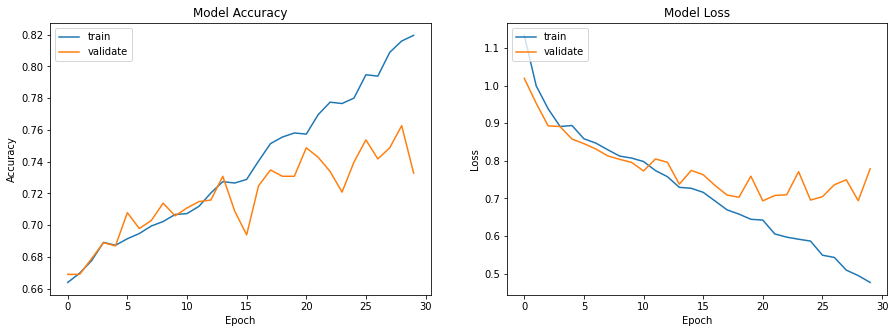

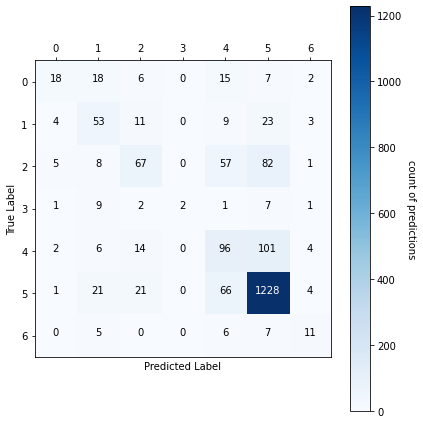

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2')) 
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                   


model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dense(256, activation='relu', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    metrics=["accuracy"],
)
x_train, y_train = unison_shuffle(x_train, y_train)

history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 128)        

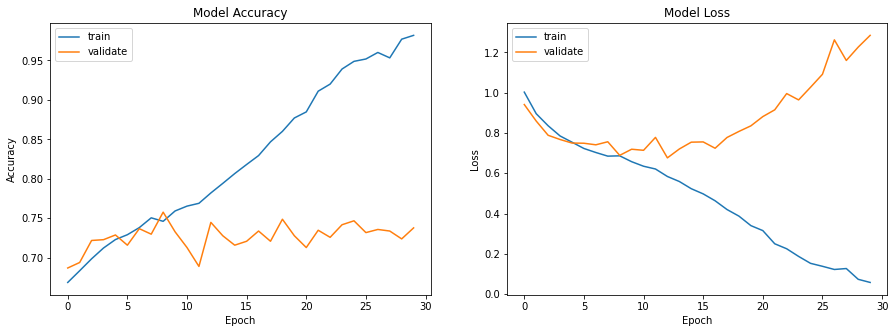

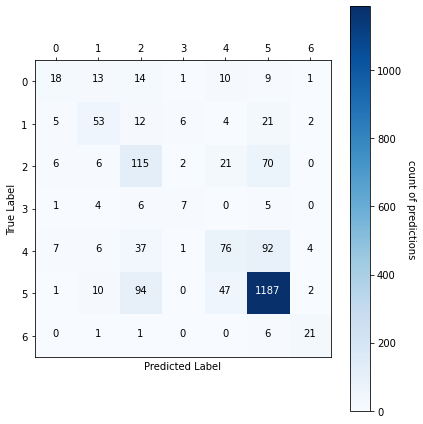

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='tanh', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='tanh', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='tanh', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='tanh', name='block2_conv2')) 
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))


model.add(Conv2D(128, (3, 3), padding='same', activation='tanh', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='tanh', name='block3_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='tanh', name='fc1'))
model.add(Dense(256, activation='tanh', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    metrics=["accuracy"],
)
x_train, y_train = unison_shuffle(x_train, y_train)

history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 128)        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00       220
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00       223
           5       0.67      1.00      0.80      1341
           6       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.10      0.14      0.11      2005
weighted avg       0.45      0.67      0.54      2005



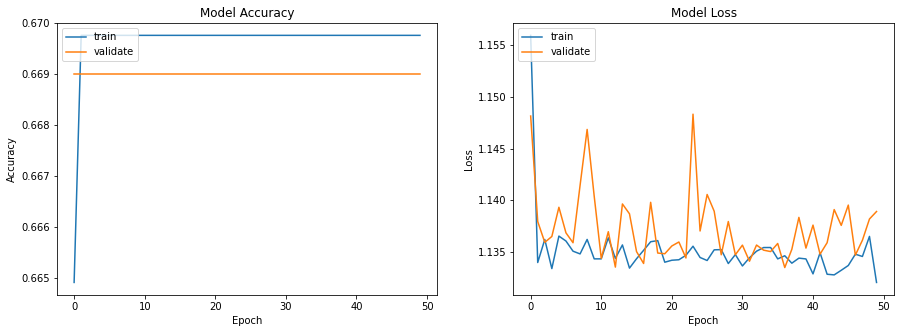

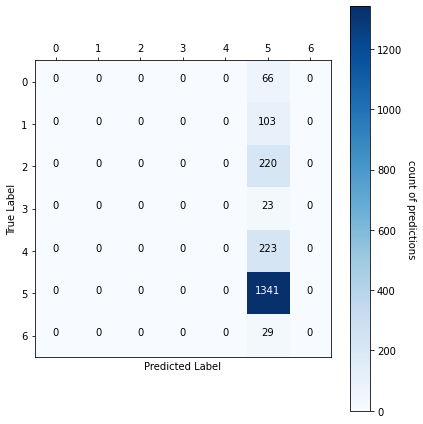

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='sigmoid', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='sigmoid', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='sigmoid', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='sigmoid', name='block2_conv2')) 
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                   


model.add(Conv2D(128, (3, 3), padding='same', activation='sigmoid', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='sigmoid', name='block3_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='sigmoid', name='fc1'))
model.add(Dense(256, activation='sigmoid', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    metrics=["accuracy"],
)
x_train, y_train = unison_shuffle(x_train, y_train)

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 128)        

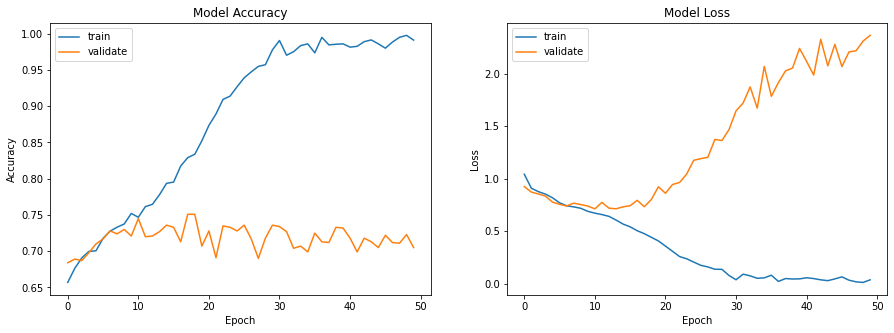

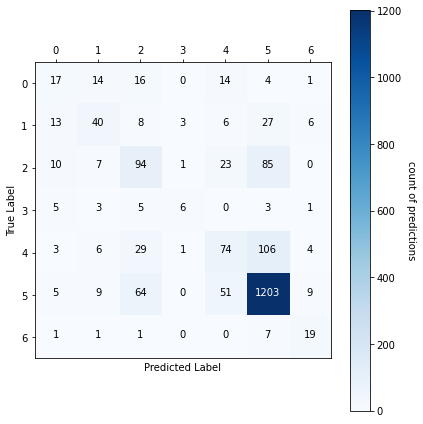

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='linear', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='linear', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='linear', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='linear', name='block2_conv2')) 
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                   


model.add(Conv2D(128, (3, 3), padding='same', activation='linear', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='linear', name='block3_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='linear', name='fc1'))
model.add(Dense(256, activation='linear', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    metrics=["accuracy"],
)
x_train, y_train = unison_shuffle(x_train, y_train)

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 128)        

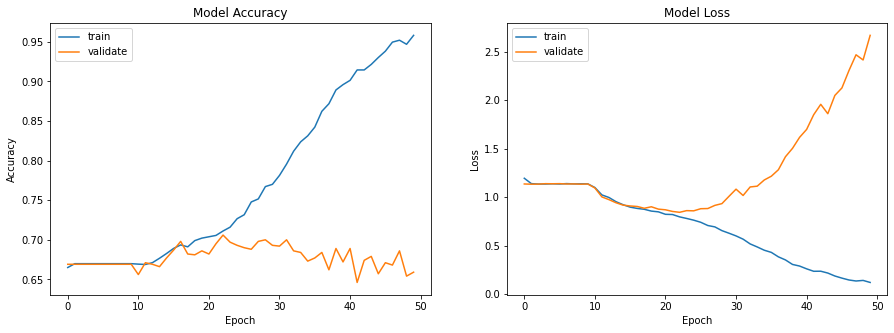

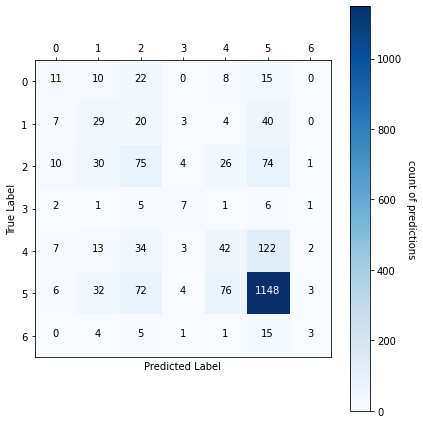

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='softplus', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='softplus', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='softplus', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='softplus', name='block2_conv2')) 
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                   


model.add(Conv2D(128, (3, 3), padding='same', activation='softplus', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='softplus', name='block3_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='softplus', name='fc1'))
model.add(Dense(256, activation='softplus', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    metrics=["accuracy"],
)
x_train, y_train = unison_shuffle(x_train, y_train)

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 128)       

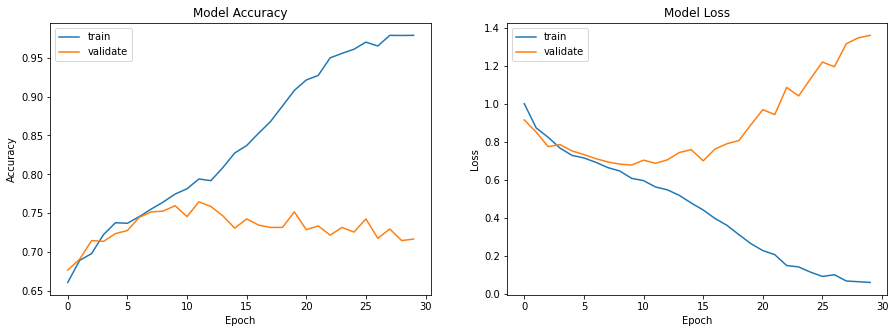

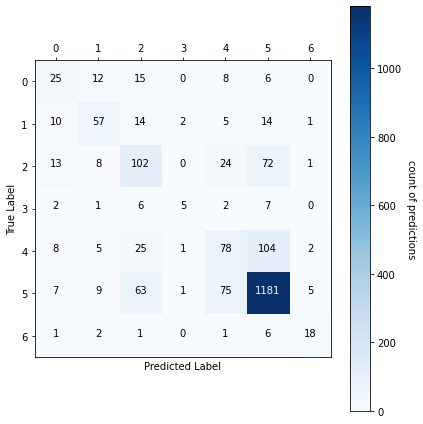

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='tanh', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='tanh', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='tanh', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='tanh', name='block2_conv2')) 
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))


model.add(Conv2D(128, (3, 3), padding='same', activation='tanh', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='tanh', name='block3_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='tanh', name='fc1'))
model.add(Dense(256, activation='tanh', name='fc2'))
model.add(Dense(7, activation='sigmoid', name='predictions'))

model.summary()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    metrics=["accuracy"],
)
x_train, y_train = unison_shuffle(x_train, y_train)

history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 128)       

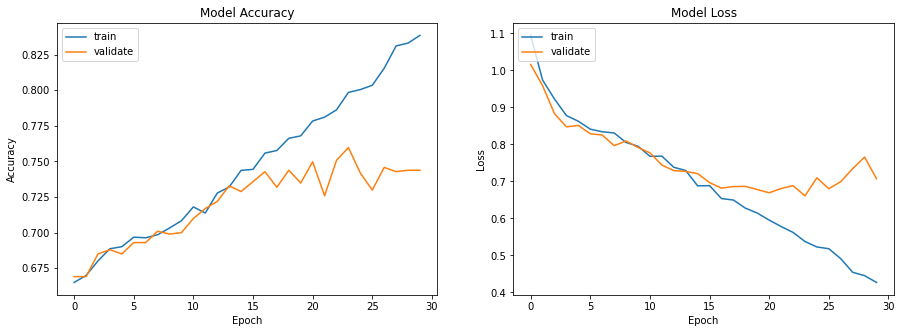

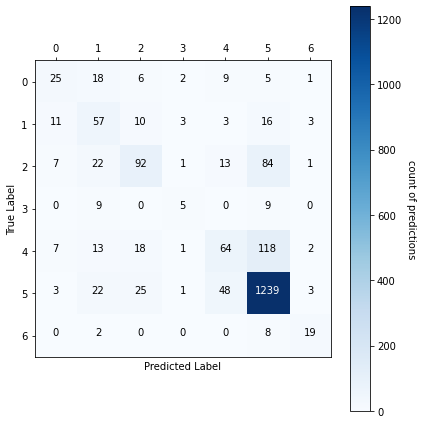

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2')) 
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                   


model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dense(256, activation='relu', name='fc2'))
model.add(Dense(7, activation='sigmoid', name='predictions'))

model.summary()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    metrics=["accuracy"],
)
x_train, y_train = unison_shuffle(x_train, y_train)

history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


# Stride + Kernel + Filter + AveragePooling

***Stride on maxpooling:***
* Maxpooling :  kernel: (2, 2)  --- stride: (2, 2) --> better evaluation metric (***small stride on maxpooling -> detect small and more pattern in data***)
* Maxpooling :  kernel: (4, 4)   ---  stride: (4, 4)
* Maxpooling :  kernel: (5, 5)   ---  stride: (2, 2) -> not good as possible because of redundant pattern

***AveragePooling:***
* result of output: maxpooling was better than averagepooling
* maybe because maxpooling output the ***Hot Point***



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 128)        

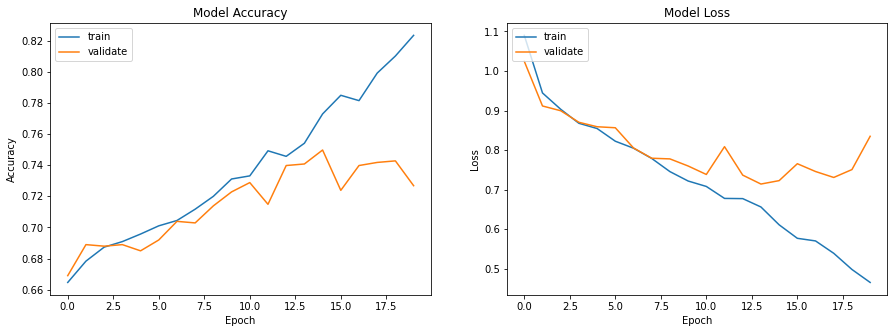

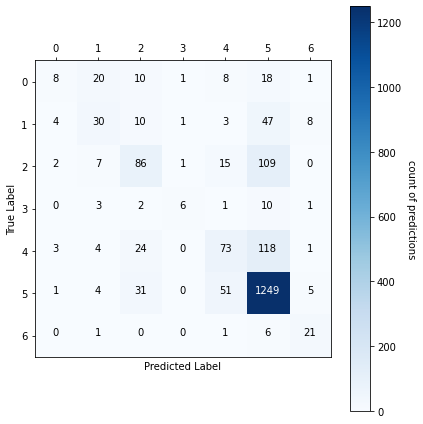

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2')) 
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))                   


model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dense(256, activation='relu', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

x_train, y_train = unison_shuffle(x_train, y_train)
history = model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 7, 7, 16)          0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 7, 7, 64)          9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 7, 7, 64)          36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 1, 1, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 1, 1, 128)       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.43      0.14      0.21        66
           1       0.41      0.53      0.46       103
           2       0.49      0.46      0.47       220
           3       0.00      0.00      0.00        23
           4       0.54      0.13      0.21       223
           5       0.81      0.95      0.88      1341
           6       0.91      0.34      0.50        29

    accuracy                           0.74      2005
   macro avg       0.51      0.37      0.39      2005
weighted avg       0.70      0.74      0.70      2005



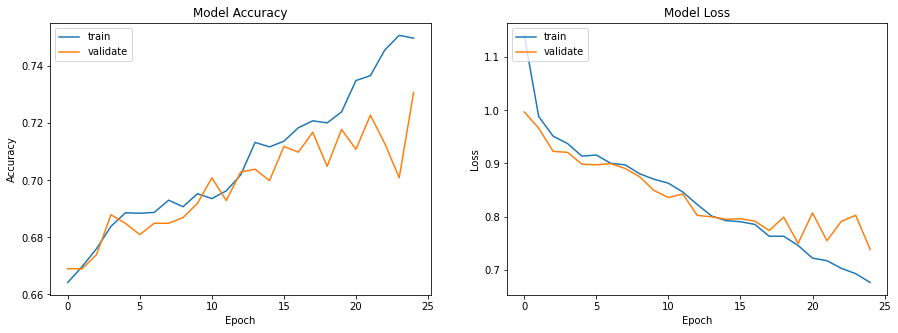

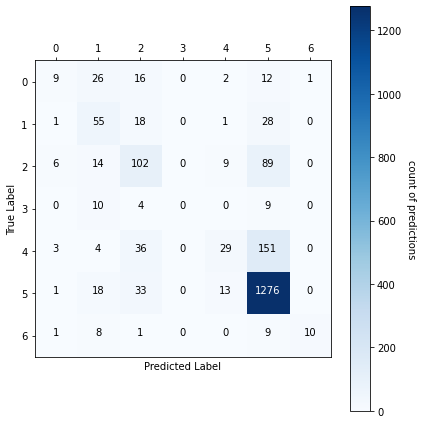

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv2'))
model.add(MaxPooling2D((4, 4), strides=(4, 4), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2')) 
model.add(MaxPooling2D((4, 4), strides=(4, 4), name='block2_pool'))                   


model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv2'))
model.add(MaxPooling2D((4, 4), padding='same', strides=(4, 4), name='block3_pool'))                   

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dense(256, activation='relu', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

x_train, y_train = unison_shuffle(x_train, y_train)
history = model.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 12, 12, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 12, 12, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 4, 4, 128)       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.35      0.21      0.26        66
           1       0.47      0.15      0.22       103
           2       0.42      0.54      0.47       220
           3       0.00      0.00      0.00        23
           4       0.38      0.48      0.42       223
           5       0.86      0.86      0.86      1341
           6       0.55      0.62      0.58        29

    accuracy                           0.71      2005
   macro avg       0.43      0.41      0.40      2005
weighted avg       0.71      0.71      0.70      2005



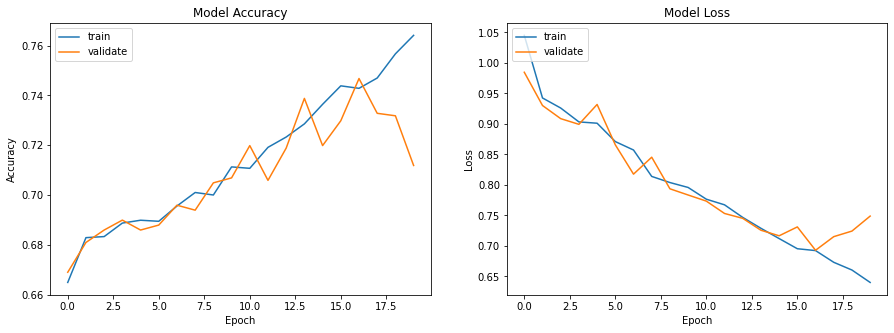

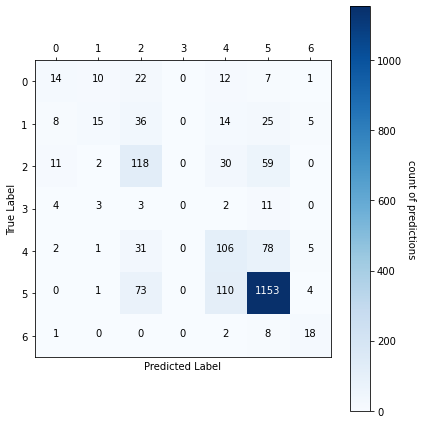

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv2'))
model.add(MaxPooling2D((5, 5), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2')) 
model.add(MaxPooling2D((5, 5), strides=(2, 2), name='block2_pool'))                   


model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv2'))
model.add(MaxPooling2D((5, 5), strides=(2, 2), padding='same', name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dense(256, activation='relu', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

x_train, y_train = unison_shuffle(x_train, y_train)
history = model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
block1_pool (AveragePooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        9280      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (AveragePooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 128)       

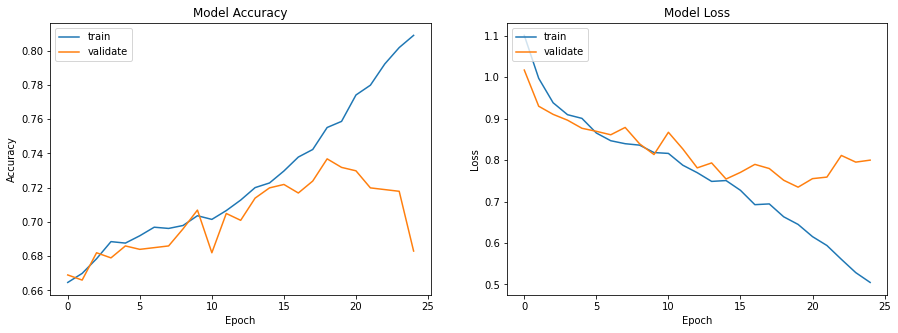

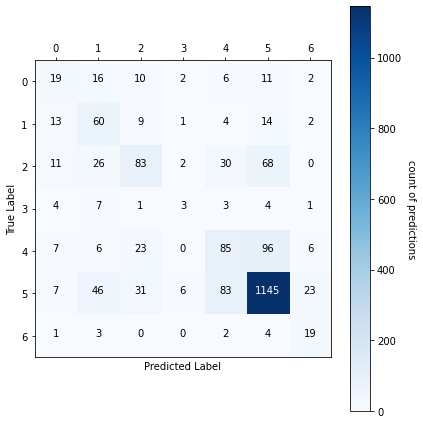

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, Dense, Flatten, InputLayer, AveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

model = Sequential()
model.add( InputLayer((28, 28, 3)))                                           

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv1'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv2'))
model.add(AveragePooling2D((2, 2), strides=(2, 2), name='block1_pool'))                  

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1')) 
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2')) 
model.add(AveragePooling2D((2, 2), strides=(2, 2), name='block2_pool'))                   


model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv2'))
model.add(AveragePooling2D((2, 2), strides=(2, 2), name='block3_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dense(256, activation='relu', name='fc2'))
model.add(Dense(7, activation='softmax', name='predictions'))
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

x_train, y_train = unison_shuffle(x_train, y_train)
history = model.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_val, y_val), verbose=1)

classification_report(model, x_test, y_test)
plotmodelhistory(history)
confusion_matrix(model, x_test, y_test)
